# RSNA Pneumonia Detection Challenge

for more detail, please visit:
https://www.kaggle.com/c/rsna-pneumonia-detection-challenge

In [1]:
import os 
import sys

import random
import math
import numpy as np
import cv2
import matplotlib.pyplot as plt
import json
import pydicom as dcm
from imgaug import augmenters as iaa
from tqdm import tqdm
import pandas as pd 
import glob

In [2]:
# from mrcnn.config import Config
from mrcnn import utils
# import mrcnn.model as modellib
# from mrcnn import visualize
# from mrcnn.model import log

D:\Anaconda\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
# a=os.getcwd()
# a

# Root directory of the project# Root  
ROOT_DIR = os.path.abspath('C:\\Users\\su_hang\\Kaggle')
# Directory to save logs and trained model
# MODEL_DIR = os.path.join(ROOT_DIR, 'logs')

In [4]:
train_dicom_dir  = os.path.join(ROOT_DIR, 'data\\stage_1_train_images')
test_dicom_dir = os.path.join(ROOT_DIR, 'data\\stage_1_test_images')

## Some setup functions and classes for Mask-RCNN
* dicom_fps is a list of the dicom image path and filenames
* image_annotions is a dictionary of the annotations keyed by the filenames
* parsing the dataset returns a list of the image filenames and the annotations dictionary

In [5]:
def get_dicom_fps(dicom_dir):
    dicom_fps = glob.glob(dicom_dir+'/'+'*.dcm')
    return list(set(dicom_fps))

def parse_dataset(dicom_dir, anns): 
    image_fps = get_dicom_fps(dicom_dir)
    image_annotations = {fp: [] for fp in image_fps}
    for index, row in anns.iterrows(): 
        fp = os.path.join(dicom_dir, row['patientId']+'.dcm')
        image_annotations[fp].append(row)
    return image_fps, image_annotations

In [6]:
class DetectorDataset(utils.Dataset):
    """Dataset class for training pneumonia detection on the RSNA pneumonia dataset.
    """

    def __init__(self, image_fps, image_annotations, orig_height, orig_width):
        super().__init__(self)
        
        # Add classes
        self.add_class('pneumonia', 1, 'Lung Opacity')
   
        # add images 
        for i, fp in enumerate(image_fps):
            annotations = image_annotations[fp]
            self.add_image('pneumonia', image_id=i, path=fp, 
                           annotations=annotations, orig_height=orig_height, orig_width=orig_width)
            
    def image_reference(self, image_id):
        info = self.image_info[image_id]
        return info['path']

    def load_image(self, image_id):
        info = self.image_info[image_id]
        fp = info['path']
        ds = pydicom.read_file(fp)
        image = ds.pixel_array
        # If grayscale. Convert to RGB for consistency.
        if len(image.shape) != 3 or image.shape[2] != 3:
            image = np.stack((image,) * 3, -1)
        return image

    def load_mask(self, image_id):
        info = self.image_info[image_id]
        annotations = info['annotations']
        count = len(annotations)
        if count == 0:
            mask = np.zeros((info['orig_height'], info['orig_width'], 1), dtype=np.uint8)
            class_ids = np.zeros((1,), dtype=np.int32)
        else:
            mask = np.zeros((info['orig_height'], info['orig_width'], count), dtype=np.uint8)
            class_ids = np.zeros((count,), dtype=np.int32)
            for i, a in enumerate(annotations):
                if a['Target'] == 1:
                    x = int(a['x'])
                    y = int(a['y'])
                    w = int(a['width'])
                    h = int(a['height'])
                    mask_instance = mask[:, :, i].copy()
                    cv2.rectangle(mask_instance, (x, y), (x+w, y+h), 255, -1)
                    mask[:, :, i] = mask_instance
                    class_ids[i] = 1
        return mask.astype(np.bool), class_ids.astype(np.int32)

## Examine the annotation data, parse the dataset, and view dicom fields

In [7]:
# training dataset
anns = pd.read_csv(os.path.join(ROOT_DIR, 'data\\stage_1_train_labels.csv'))
anns.head(6)

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1
5,00436515-870c-4b36-a041-de91049b9ab4,562.0,152.0,256.0,453.0,1


In [12]:
# image_annotations

In [13]:
image_fps, image_annotations = parse_dataset(train_dicom_dir, anns=anns)

In [14]:
ds = dcm.read_file(image_fps[0]) # read dicom image from filepath 
image = ds.pixel_array # get image array

In [ ]:
# get the pixel values for training set (only took the image pixel in the region of [100:900,200:800] (800*600))
patientID=[]
patientID.append(image_fps[0][50:86])
image  = dcm.read_file(image_fps[0]).pixel_array[100:900,200:800]
A=image.reshape((1,800*600))
for i in range(1,5000):#len(image_fps)):
    image  = dcm.read_file(image_fps[i]).pixel_array [100:900,200:800]
    a=image.reshape((1,800*600))
    patientID.append(image_fps[i][50:86])
    A = np.append(A, a,axis=0)
    if i%50==0:
        print(str(i)+'data has been processed')

50data has been processed
100data has been processed
150data has been processed
200data has been processed
250data has been processed
300data has been processed
350data has been processed
400data has been processed
450data has been processed
500data has been processed
550data has been processed
600data has been processed
650data has been processed
700data has been processed
750data has been processed
800data has been processed
850data has been processed
900data has been processed
950data has been processed
1000data has been processed
1050data has been processed
1100data has been processed
1150data has been processed
1200data has been processed
1250data has been processed
1300data has been processed
1350data has been processed
1400data has been processed
1450data has been processed
1500data has been processed
1550data has been processed
1600data has been processed
1650data has been processed
1700data has been processed
1750data has been processed
1800data has been processed
1850data has

In [83]:
# %%time?
# print('testtesteststet')

In [115]:
100%30

10

In [72]:
test=ds[100:900,200:800]

In [73]:
test.shape

(800, 600)

In [75]:
ds.shape

(800, 600)

## Get the pixel values for testing set

In [19]:
image_fps[0]

'C:\\Users\\su_hang\\Kaggle\\data\\stage_1_train_images\\084d42b9-0a43-490d-9a8d-e4d7545c44f5.dcm'

In [18]:
test_dcm_fps[0]

'data/stage_1_test_images\\000924cf-0f8d-42bd-9158-1af53881a557.dcm'

In [8]:
# test_dcm_fps  is the path of the image file
test_dcm_fps = glob.glob('data/stage_1_test_images/*.dcm')

In [35]:
# get the pixel values for testing set (only took the image pixel in the region of [100:900,200:800] (800*600))
patientID=[]
patientID.append(test_dcm_fps[0][25:61])
image  = dcm.read_file(test_dcm_fps[0]).pixel_array[100:900,200:800]
A=image.reshape((1,800*600))
for i in range(1,len(test_dcm_fps)):
    image  = dcm.read_file(test_dcm_fps[i]).pixel_array [100:900,200:800]
    a=image.reshape((1,800*600))
    patientID.append(image_fps[i][50:86])
    A = np.append(A, a,axis=0)
    if (i+1)%50==0:
        print(str(i)+' data has been processed')

49 data has been processed
99 data has been processed
149 data has been processed
199 data has been processed
249 data has been processed
299 data has been processed
349 data has been processed
399 data has been processed
449 data has been processed
499 data has been processed
549 data has been processed
599 data has been processed
649 data has been processed
699 data has been processed
749 data has been processed
799 data has been processed
849 data has been processed
899 data has been processed
949 data has been processed
999 data has been processed


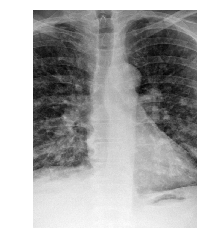

In [28]:
plt.imshow(A[3].reshape((800,600)), cmap='gray')
plt.axis('off')
plt.show()

In [68]:
df1=pd.DataFrame(data=patientID,columns=['patientID'])
df2=pd.DataFrame(data=A)
df=pd.concat([df1,df2],axis=1)

In [72]:
df.to_csv('Test data(100-900,200-800).csv',index=False)

In [70]:
df.to_csv?

In [57]:
test=list(range(480000))

In [59]:
test[-3:]

[479997, 479998, 479999]

In [60]:
df_test=pd.DataFrame(data=A)

In [61]:
df_test.head()

,0,1,2,3,4,5,6,7,8,9,...,479990,479991,479992,479993,479994,479995,479996,479997,479998,479999
0,107,106,106,107,108,109,109,109,111,114,...,174,174,176,171,168,169,169,168,167,168
1,3,3,3,3,3,3,3,3,3,3,...,152,152,153,153,153,152,152,152,152,152
2,60,60,61,61,60,60,61,61,63,63,...,151,150,148,148,148,148,147,147,146,146
3,93,92,90,90,91,92,91,90,89,88,...,192,189,193,193,193,194,194,193,192,191
4,91,93,94,93,92,94,96,97,91,91,...,137,138,138,138,137,137,136,135,135,137


In [45]:
A[:,1].shape

(1000,)

---

In [ ]:
# show dicom fields 
ds

In [ ]:
# Original DICOM image size: 1024 x 1024
ORIG_SIZE = 1024

## Split the data into training and validation datasets

* To use all the images do: image_fps_list = list(image_fps)
* Or change the number of images from 100 to a custom number

In [ ]:
######################################################################
# Modify this line to use more or fewer images for training/validation. 
# To use all images, do: image_fps_list = list(image_fps)
image_fps_list = list(image_fps[:1000]) 
#####################################################################

# split dataset into training vs. validation dataset 
# split ratio is set to 0.9 vs. 0.1 (train vs. validation, respectively)
sorted(image_fps_list)
random.seed(42)
random.shuffle(image_fps_list)

validation_split = 0.1
split_index = int((1 - validation_split) * len(image_fps_list))

image_fps_train = image_fps_list[:split_index]
image_fps_val = image_fps_list[split_index:]

print(len(image_fps_train), len(image_fps_val))

### Create and prepare the training dataset using the DetectorDataset class.

In [ ]:
# prepare the training dataset
dataset_train = DetectorDataset(image_fps_train, image_annotations, ORIG_SIZE, ORIG_SIZE)
dataset_train.prepare()

### Let's look at a sample annotation. We see a bounding box with (x, y) of the the top left corner as well as the width and height.

In [ ]:
image_fps_train[1]

In [ ]:
# Show annotation(s) for a DICOM image # Show  
test_fp = random.choice(image_fps_train)
image_annotations[test_fp]

In [ ]:
# prepare the validation dataset# prepa 
dataset_val = DetectorDataset(image_fps_val, image_annotations, ORIG_SIZE, ORIG_SIZE)
dataset_val.prepare()

### Display a random image with bounding boxes

In [ ]:
# Load and display random samples and their bounding boxes
# Suggestion: Run this a few times to see different examples. 

image_id = random.choice(dataset_train.image_ids)
image_fp = dataset_train.image_reference(image_id)
image = dataset_train.load_image(image_id)
mask, class_ids = dataset_train.load_mask(image_id)

print(image.shape)

plt.figure(figsize=(10, 10))
plt.subplot(1, 3, 1)
plt.imshow(image[:,:, 0], cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(image[100:900,200: 800, 0], cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 3)
masked = np.zeros(image.shape[:2])
for i in range(mask.shape[2]):
    masked += image[:, :, 0] * mask[:, :, i]
plt.imshow(masked, cmap='gray')
plt.axis('off')

print(image_fp)
print(class_ids)

### Image Augmentation. Try finetuning some variables to custom values

In [ ]:
# Image augmentation 
augmentation = iaa.SomeOf((0, 1), [
    iaa.Fliplr(0.5),
    iaa.Affine(
        scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
        translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
        rotate=(-25, 25),
        shear=(-8, 8)
    ),
    iaa.Multiply((0.9, 1.1))
])

## Now it's time to train the model. Note that training even a basic model can take a few hours.

Note: the following model is for demonstration purpose only. We have limited the training to one epoch, and have set nominal values for the Detector Configuration to reduce run-time.

* dataset_train and dataset_val are derived from DetectorDataset
* DetectorDataset loads images from image filenames and masks from the annotation data
* model is Mask-RCNN

In [ ]:
model = modellib.MaskRCNN(mode='training', config=config, model_dir=MODEL_DIR)

In [ ]:
# to see if can solve the error prolbem
dataset_all = DetectorDataset(image_fps_list, image_annotations, ORIG_SIZE, ORIG_SIZE)
dataset_all.prepare()

In [ ]:
NUM_EPOCHS = 1

# Train Mask-RCNN Model 
import warnings 
warnings.filterwarnings("ignore")
model.train(dataset_train, dataset_val,
# model.train(dataset_all, dataset_val,
            learning_rate=config.LEARNING_RATE,
            epochs=NUM_EPOCHS,
            layers='all',
            augmentation=augmentation
           )

In [ ]:
model.train?

In [ ]:
# max(model.anchors[:,3])
model.